## Semi-supervised Learning using Sklearn & Tensorflow (AutoEncoders)

Semi-supervised learning is a type of machine learning that combines both labeled and unlabeled data to improve the learning accuracy. In the real-world, having plenty of unlabeled data and little label data is common, because labeling data reliably is time-consuming and expensive, so it's normal to have only a few human-labeled instances.

### Data
The dataset used is the fashion mnist dataset, mainly because of its high dimensionality. The dataset consists of 28 x 28 pixel images that will be flattened.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import copy

# scikit learn
from sklearn.model_selection import train_test_split
from sklearn.semi_supervised import LabelPropagation, LabelSpreading, SelfTrainingClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# tensorflow-keras
import tensorflow as tf
from tensorflow import keras

2024-08-29 21:17:30.069088: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-29 21:17:30.163660: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-29 21:17:30.190662: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-29 21:17:30.371518: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-29 21:17:31.811345: W tensorflow/compiler/tf2

In [2]:
# loading and normalizing the dataset
fashion_mnist = keras.datasets.fashion_mnist.load_data()
(X_train, y_train), (X_test, y_test) = fashion_mnist
X_train = X_train.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

### Training a baseline model

In [ ]:
# svm_clf = SVC(kernel="rbf", random_state=42)
# svm_clf.fit(X_train[-500:].reshape(-1,784), y_train[-500:])

# get_metrics(svm_clf)

## 1. Sklearn

sklearn has three algorithms for tackling unsupervised learning tasks, the first two we will look at is...
#### a. Label Propagation & Label Spreading

The main idea behind `LabelPropagation` is that labels from labeled data are propagated to unlabeled data by constructing a graph where nodes represent data points, and edges represent similarities between them. Labels from known nodes are spread to neighboring unlabeled nodes based on similarity.

`LabelSpreading` is similar to `LabelPropagation`, however it incorporates a regularization term that smooths the labels, ensuring the that labels change smoothly and more conservatively across the graph.

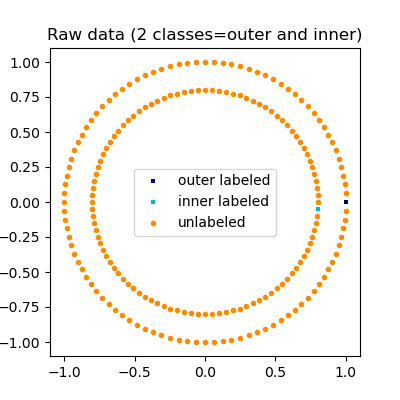


In [98]:
# helper function for preparing dataset
def create_unlabelled_targets(data, target, package, subset=1_000, size=20_000):
    if package == "sklearn":
        indices = np.random.choice(target.size, size=size, replace=False)
        y = copy.deepcopy(target).astype(np.int8) # mnist is immutable so we need to make a deep copy 
        X, y = data[indices], y[indices]
        y[:-subset] = -1        
        return X.reshape(-1, 784), y
    
    elif package == 'keras':
        X_train_labelled = data[-subset:]
        y_train_labelled = target[-subset:]
        return X_train_labelled, y_train_labelled
    
    else:
        raise ValueError("Unsupported package. Choose either 'sklearn' or 'keras'")

In [31]:
def get_metrics(model, y_true=y_test, test_set=X_test.reshape(-1, 784), package="sklearn"):
    if package == "sklearn":
        y_pred = model.predict(test_set)  
    else:
        y_pred = np.argmax(model.predict(test_set), axis=1)  
    accuracy = accuracy_score(y_true, y_pred)
    f1score = f1_score(y_true, y_pred, average="weighted")
    report = classification_report(y_true, y_pred)
    print(f"""{model.__class__.__name__} metrics
--------------------------------------
1. accuracy score: {accuracy:.2%}
2. f1_score: {f1score: .2%}
3. classification report: \n{report}
          """)

In [5]:
# applying function 
sk_train, sk_target = create_unlabelled_targets(X_train, y_train, package="sklearn")

In [6]:
sk_train.shape

(20000, 784)

We will only be working with 20_000 instances out of 60_000 because both `LabelPropagation` and `LabelSpreading` struggle with high-dimensional data as we will see. Dimensionality can be reduced using two methods
1. csr matrix (if most of your data is sparse, i.e contains 0's)
2. pca

both methods had little impact on model performance, but helped sped up training. However, we will not be using any here

The assumption here is that only 5%, i.e 1_000 of our dataset is labeled, as implemented in the helper function above. This assumption is in line with the recommended 5% - 10% required to have a meaningful result when performing semi-supervised learning. 

In [7]:
# instantiating both algorithms
 
label_prop_model = LabelPropagation()
label_spread_model = LabelSpreading()

models = [label_prop_model, label_spread_model]

In [8]:
for model in models:
    print(f"Training the {model.__class__.__name__} algorithm")
    model.fit(sk_train, sk_target)

Training the LabelPropagation algorithm
Training the LabelSpreading algorithm


In [9]:
# label propagation
get_metrics(label_prop_model)

LabelPropagation metrics
--------------------------------------
1. accuracy score: 13.05%
2. f1_score:  7.12%
3. classification report: 
              precision    recall  f1-score   support

           0       0.10      0.99      0.19      1000
           1       1.00      0.24      0.39      1000
           2       1.00      0.01      0.02      1000
           3       1.00      0.00      0.00      1000
           4       1.00      0.00      0.01      1000
           5       1.00      0.01      0.02      1000
           6       0.81      0.03      0.06      1000
           7       1.00      0.02      0.04      1000
           8       0.00      0.00      0.00      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.13     10000
   macro avg       0.69      0.13      0.07     10000
weighted avg       0.69      0.13      0.07     10000

          


In [10]:
# label spreading
get_metrics(label_spread_model)

LabelSpreading metrics
--------------------------------------
1. accuracy score: 12.99%
2. f1_score:  7.09%
3. classification report: 
              precision    recall  f1-score   support

           0       0.10      0.99      0.19      1000
           1       1.00      0.23      0.38      1000
           2       1.00      0.01      0.02      1000
           3       1.00      0.00      0.00      1000
           4       1.00      0.00      0.01      1000
           5       1.00      0.01      0.02      1000
           6       0.76      0.03      0.06      1000
           7       1.00      0.02      0.04      1000
           8       0.00      0.00      0.00      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.13     10000
   macro avg       0.69      0.13      0.07     10000
weighted avg       0.69      0.13      0.07     10000

          


### b. SelfTraining Classifier (RandomForestClassifier)

In [97]:
sk_target.shape

(20000,)

In [99]:
sk_train, sk_target = create_unlabelled_targets(X_train, y_train, package="sklearn", subset=3_000, size=60_000)

In [100]:
clf = SelfTrainingClassifier(base_estimator=RandomForestClassifier(random_state=42))

In [101]:
clf.fit(sk_train, sk_target)

SelfTrainingClassifier(base_estimator=RandomForestClassifier(random_state=42))

In [102]:
get_metrics(clf)

SelfTrainingClassifier metrics
--------------------------------------
1. accuracy score: 79.14%
2. f1_score:  77.89%
3. classification report: 
              precision    recall  f1-score   support

           0       0.76      0.78      0.77      1000
           1       0.98      0.92      0.95      1000
           2       0.62      0.70      0.66      1000
           3       0.67      0.89      0.77      1000
           4       0.59      0.72      0.65      1000
           5       0.96      0.91      0.94      1000
           6       0.67      0.22      0.33      1000
           7       0.89      0.88      0.89      1000
           8       0.91      0.96      0.93      1000
           9       0.88      0.93      0.90      1000

    accuracy                           0.79     10000
   macro avg       0.79      0.79      0.78     10000
weighted avg       0.79      0.79      0.78     10000

          


In [ ]:
# encoder = keras.Sequential([
#     keras.layers.Input(shape=[28, 28]),
#     keras.layers.Flatten(),
#     keras.layers.Dense(300, activation="relu"),
#     keras.layers.Dense(150, activation="relu"),
#     keras.layers.Dense(64, activation="relu")
# ])

# decoder = keras.Sequential([
#     keras.layers.Dense(150, activation="relu"),
#     keras.layers.Dense(300, activation="relu"),
#     keras.layers.Dense(28 * 28, activation="sigmoid"),
#     keras.layers.Reshape([28, 28])
# ])

# autoencoder = keras.Sequential([encoder, decoder])

In [163]:
keras_train, keras_target = create_unlabelled_targets(X_train, y_train, package="keras", subset=3_000)

In [165]:
keras.backend.clear_session()
tf.random.set_seed(42)

encoder = keras.Sequential([
    keras.layers.Input(shape=[28, 28]),
    keras.layers.Flatten(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(200, activation="relu"),
    keras.layers.Dense(100, activation="relu")
])

decoder = keras.Sequential([
    keras.layers.Dense(200, activation="relu"),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

autoencoder = keras.Sequential([encoder, decoder])

autoencoder.compile(loss="binary_crossentropy", optimizer="nadam", metrics=["mse"])

ae_EarlyStopping_cb = keras.callbacks.EarlyStopping(patience=10, monitor="val_mse", restore_best_weights=True)

history = autoencoder.fit(X_train, X_train, validation_split=0.2, epochs=100, callbacks=[ae_EarlyStopping_cb])

Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.3396 - mse: 0.0337 - val_loss: 0.2869 - val_mse: 0.0146
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.2839 - mse: 0.0141 - val_loss: 0.2791 - val_mse: 0.0120
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.2771 - mse: 0.0118 - val_loss: 0.2755 - val_mse: 0.0108
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.2736 - mse: 0.0106 - val_loss: 0.2730 - val_mse: 0.0099
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.2712 - mse: 0.0098 - val_loss: 0.2711 - val_mse: 0.0094
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.2694 - mse: 0.0093 - val_loss: 0.2701 - val_mse: 0.0090
Epoch 7/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.2681 - mse: 0.0088 - val_loss: 0.2690 - val_mse: 0.0087
Epoch 8/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.2671 - mse: 0.0085 - val_loss: 0.2679 - val_mse: 0.0083
Epoch 9/100
1500/1500 ━━━━━━━━━━

In [166]:
for layer in encoder.layers:
    layer.trainable = False

In [169]:
keras.backend.clear_session()
tf.random.set_seed(44)

clf_dnn = keras.Sequential([
    encoder,
    # keras.layers.Dense(150, activation="relu"),
    # keras.layers.Dropout(0.25),
    keras.layers.Dense(50, activation="relu"),
    # keras.layers.Dropout(0.3),
    keras.layers.Dense(10, activation="softmax")
])

clf_dnn.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

EarlyStopping_cb = keras.callbacks.EarlyStopping(patience=20, monitor="val_accuracy", restore_best_weights=True)

history_clf = clf_dnn.fit(keras_train, keras_target, validation_split=0.2, epochs=100, callbacks=[EarlyStopping_cb])

Epoch 1/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.2346 - loss: 2.3842 - val_accuracy: 0.6383 - val_loss: 1.2185
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6933 - loss: 1.0881 - val_accuracy: 0.7267 - val_loss: 0.8525
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7533 - loss: 0.8080 - val_accuracy: 0.7417 - val_loss: 0.7246
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7811 - loss: 0.6985 - val_accuracy: 0.7517 - val_loss: 0.6599
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7946 - loss: 0.6380 - val_accuracy: 0.7700 - val_loss: 0.6191
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8052 - loss: 0.5961 - val_accuracy: 0.7800 - val_loss: 0.5920
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8093 - loss: 0.5656 - val_accuracy: 0.7883 - val_loss: 0.5710
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8200 - loss: 0.5391 - val_accuracy: 0.7917 - 

In [168]:
get_metrics(model=clf_dnn, package="keras")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Sequential metrics
--------------------------------------
1. accuracy score: 83.22%
2. f1_score:  83.16%
3. classification report: 
              precision    recall  f1-score   support

           0       0.78      0.81      0.79      1000
           1       0.99      0.93      0.96      1000
           2       0.73      0.70      0.71      1000
           3       0.84      0.85      0.85      1000
           4       0.68      0.77      0.72      1000
           5       0.94      0.91      0.92      1000
           6       0.62      0.56      0.59      1000
           7       0.91      0.91      0.91      1000
           8       0.93      0.95      0.94      1000
           9       0.91      0.95      0.93      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000

          


In [71]:
X_train.shape

(60000, 28, 28)

In [45]:
def get_metrics(model, y_true=y_test, test_set=X_test, package="sklearn"):
    if package == "sklearn":
        y_pred = model.predict(test_set.reshape(-1, 784))  
    elif package == "keras":
        y_pred = np.argmax(model.predict(X_test), axis=1) 
    accuracy = accuracy_score(y_true, y_pred)
    f1score = f1_score(y_true, y_pred, average="weighted")
    report = classification_report(y_true, y_pred)
    print(f"""{model.__class__.__name__} metrics
--------------------------------------
1. accuracy score: {accuracy:.2%}
2. f1_score: {f1score: .2%}
3. classification report: \n{report}
          """)

In [ ]:
ls = (label_spread_model, sk_target, "Label Spreading")
lp = (label_prop_model, sk_target, "Label Propagation")
sc = (clf, sk_target, "Self Training Classifier")

classifiers = (ls, lp, sc)



In [141]:
import sklearn.datasets
iris = sklearn.datasets.load_iris()

X = iris.data[:, :2]
y = iris.target

In [146]:
h = 0.02

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

In [155]:
(np.c_[xx.ravel(), yy.ravel()]).shape

(61600, 2)

In [159]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

knn_clf = KNeighborsClassifier(n_neighbors=3)
svm_clf = SVC(kernel='rbf', random_state=42, probability=True)
rnd_clf = RandomForestClassifier(random_state=42)
a = [knn_clf, svm_clf, rnd_clf]

for b in a:
    b.fit(X_train[-3000:].reshape(-1, 784), y_train[-3000:])

In [ ]:
# svm_clf = SVC(kernel="rbf", random_state=42)
# svm_clf.fit(X_train[-500:].reshape(-1,784), y_train[-500:])

# get_metrics(svm_clf)

In [160]:
get_metrics(knn_clf)

KNeighborsClassifier metrics
--------------------------------------
1. accuracy score: 78.01%
2. f1_score:  78.08%
3. classification report: 
              precision    recall  f1-score   support

           0       0.66      0.81      0.73      1000
           1       0.98      0.93      0.95      1000
           2       0.61      0.67      0.64      1000
           3       0.86      0.77      0.81      1000
           4       0.68      0.63      0.65      1000
           5       0.98      0.71      0.83      1000
           6       0.52      0.50      0.51      1000
           7       0.80      0.92      0.86      1000
           8       0.97      0.91      0.94      1000
           9       0.85      0.95      0.89      1000

    accuracy                           0.78     10000
   macro avg       0.79      0.78      0.78     10000
weighted avg       0.79      0.78      0.78     10000

          


In [161]:
get_metrics(rnd_clf)

RandomForestClassifier metrics
--------------------------------------
1. accuracy score: 82.22%
2. f1_score:  81.84%
3. classification report: 
              precision    recall  f1-score   support

           0       0.77      0.82      0.79      1000
           1       0.99      0.93      0.96      1000
           2       0.70      0.68      0.69      1000
           3       0.82      0.87      0.85      1000
           4       0.64      0.79      0.71      1000
           5       0.93      0.92      0.93      1000
           6       0.65      0.43      0.52      1000
           7       0.90      0.88      0.89      1000
           8       0.92      0.96      0.94      1000
           9       0.90      0.94      0.92      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000

          


In [162]:
get_metrics(svm_clf)

SVC metrics
--------------------------------------
1. accuracy score: 81.90%
2. f1_score:  81.55%
3. classification report: 
              precision    recall  f1-score   support

           0       0.72      0.82      0.77      1000
           1       1.00      0.93      0.96      1000
           2       0.71      0.69      0.70      1000
           3       0.81      0.85      0.83      1000
           4       0.69      0.79      0.74      1000
           5       0.92      0.90      0.91      1000
           6       0.59      0.43      0.50      1000
           7       0.89      0.90      0.90      1000
           8       0.93      0.95      0.94      1000
           9       0.91      0.93      0.92      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000

          
